## Bachelor Thesis - Informatik

### Variante 3 :
### Multiclass-Klassifizierung mit 1D Convolutional Neuronal Network
***

<div align="left">
<h2><img src="https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExZ2hrOGtveWx0ZGxsaGFsYXNzbjVhOTNyaTg2cG44anZ5eWd5a3ZyMyZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/l3vRcrVqhBVSpJte0/giphy.gif" width="200" alt="Data"></h2>
</div>

Beschreibung der zugrunde liegenden Daten :

###### ☑️ Die Daten wurden von einem Myo-Armband per Bluetooth LE an einen ESP32S3 übertragen

###### ☑️ Sämtliche Daten wurden mit folgender Lösung [Processing-Grapher](https://github.com/chillibasket/processing-grapher.git) aufgezeichnet und als .csv-Datei gespeichert

###### ☑️ Vier Testpersonen, davon eine weibliche und drei männliche Personen standen zur Verfügung

###### ☑️ Alle Personen haben die folgenden vier Gesten in gleicher Position ausgeführt :

<img src="./Gestenbilder/Eigene_Geste_0.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_1.png" width="150">    <img src="./Gestenbilder/Eigene_Geste_2.png" width="150">      <img src="./Gestenbilder/Eigene_Geste_3.png" width="150">



##### ▶️ Installation notwendiger Python-Bibliotheken
***

In [1]:
##############################################################
#      Dieses Notebook wurde mit Python 3.9.13 getestet      #
#                                                            #
#           Andere Versionen haben teilweise                 #
#           Kompatbilitätsprobleme verursacht                #
#                                                            #
#      This Notebook was tested with Python 3.9.13           #
#                                                            #
#              Other Versions can cause                      #
#                Compatibilityproblems                       #
#                                                            #
##############################################################

In [2]:
##############################################################
# Achtung!! Die Konvertierung des Modells nach C++           #
#           funktioniert nur mit Tensorflow <=2.15.1         #
#           Keras 3 funktioniert nicht!                      #
#                                                            #
# Attention! Converting the model to C++ ist only working    #
#            with Tensorflow <=2.15.1                        #
#            Keras 3 will not work!                          #
##############################################################
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\Gizmo\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


##### ▶️ Importieren notwendiger Python-Bibliotheken
***

In [3]:
import pandas as pd # type: ignore
import numpy as np # type: ignore
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore

from sklearn.model_selection import train_test_split # type: ignore
from sklearn.metrics import classification_report, confusion_matrix # type: ignore
from sklearn.preprocessing import MinMaxScaler, StandardScaler # type: ignore

import tensorflow as tf # type: ignore
from tensorflow import keras # type: ignore
from keras import layers # type: ignore

import logging
tf.get_logger().setLevel(logging.ERROR)

##### ▶️ Einlesen der aufgezeichneten Daten aus dem Quellordner<br>
****

In [4]:
# Importiere die .csv-Dateien mit den EMG-Daten der einzelnen Probanden und den einzelnen Labels (Gesten)
# Dabei gilt folgendes Schema, siehe auch Bilder im Ordner "Gestenbilder"
# Label 0 --> Faust
# Label 1 --> Daumen hoch
# Label 2 --> Schere
# Label 3 --> Gespreizte Hand


##############################################################
# Aufnahme der Einzelgesten                                  #
# Datentyp: Python List                                      #
##############################################################
proband1 = []
proband2 = []
proband3 = []
proband4 = []


##############################################################
# Baue daraus den Dateipfad und lese Datei ein               #
# Schreibe Nummer der Geste in entsprechende Spalte          #
##############################################################
for label in ['0', '1', '2', '3']:
    proband1.append(pd.read_csv('./Eigene Datenaufzeichnungen/P1L' + label + '.csv', sep=',', header=None))    
    proband1[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband2.append(pd.read_csv('./Eigene Datenaufzeichnungen/P2L' + label + '.csv', sep=',', header=None))    
    proband2[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband3.append(pd.read_csv('./Eigene Datenaufzeichnungen/P3L' + label + '.csv', sep=',', header=None))    
    proband3[int(label)][64] = int(label)

for label in ['0', '1', '2', '3']:
    proband4.append(pd.read_csv('./Eigene Datenaufzeichnungen/P4L' + label + '.csv', sep=',', header=None))    
    proband4[int(label)][64] = int(label)


##############################################################
# Schreibe alle Unterlisten in jeweils ein Dataframe         #
# Datentyp: Pandas Dataframe                                 #
##############################################################
proband1 = pd.concat([df for df in proband1], axis=0).reset_index(drop=True)
proband2 = pd.concat([df for df in proband2], axis=0).reset_index(drop=True)
proband3 = pd.concat([df for df in proband3], axis=0).reset_index(drop=True)
proband4 = pd.concat([df for df in proband4], axis=0).reset_index(drop=True)


##############################################################
# Schreibe alle Sub-Dataframes in ein gesamtes Dataframe     #
# Datentyp: Pandas Dataframe                                 #
##############################################################
all_data = pd.concat([proband1, proband2, proband3, proband4]).reset_index(drop=True)

##### ▶️ Umwandlung der Daten in geeignete Formate

In [5]:
##############################################################
# Einzelwerte der Labels auslesen                            #
# Datentyp Pandas Dataframe                                  #
##############################################################
Labels = all_data[all_data.columns[-1]]
Labels = np.array(Labels).astype('int')
Labels = np.expand_dims(Labels, -1)


##############################################################
# Klassen aus den Labels auslesen                            #
# Datentyp Numpy Array                                       #
##############################################################
Klassen = np.unique(Labels)
Klassen = np.expand_dims(Klassen, -1)
Anzahl_Klassen = Klassen.max() + 1
print("Anzahl der Klassen : ", Anzahl_Klassen)
print("Form der Klassen : ", Klassen.shape)


##############################################################
# Features der Gesten auslesen                               #
# Datentyp Pandas Dataframe                                  #
##############################################################
Features = all_data.drop(64, axis=1).copy()
Features = np.array(Features).astype('float32')
Features = Features.reshape(-1,64)


##############################################################
# Gebe die Form des Image-Vectors aus                        #
##############################################################
print("Form der Features : ", Features.shape)


##############################################################
# Gebe die Form des Label-Vectors aus                        #
##############################################################
print("Form der Labels : ", Labels.shape)

Anzahl der Klassen :  4
Form der Klassen :  (4, 1)
Form der Features :  (6064, 64)
Form der Labels :  (6064, 1)


#### ▶️ Normalisierung der Daten (Optional)
***

In [6]:
##############################################################
# Datenskalierung mit Z-Score                                #
##############################################################  
sc = StandardScaler()


##############################################################
# Normalisierung durchführen                                 #
# Datentyp Numpy Array                                       #
##############################################################  
Features = sc.fit_transform(Features)
Features = np.expand_dims(Features, -1)

#### ▶️ Datensatz aufteilen in Training-, Test-, und Validierungsdaten
***

In [7]:
##############################################################
# 64 x 1 Matrix --> 1D Arrays für CNN-Modell                 #
##############################################################
input_shape = (64, 1)


##############################################################
# Aufteilung der Datensätze in Training- und Testdaten       #
# Test-Size --> prozentualer Anteil von Gesamtdaten          #
# Random-State --> Zufallsgrad der Durchmischung             #
##############################################################
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size = 0.15, random_state = 100)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.15, random_state=100)


##############################################################
# Status der Datensätze ausgeben                             #
##############################################################
print("Form der Training-Features : ", X_train.shape)
print("Form der Test-Features : ", X_test.shape)
print("Form der Validierungs-Features:", X_val.shape)
print("---------------------------------")
print("Form der Training-Labels : ", y_train.shape)
print("Form der Test-Labels : ", y_test.shape)
print("Form der Validierungs-Labels : ", y_val.shape)
print("---------------------------------")
print(Features.shape[0], "Gesamt-Features")
print(X_train.shape[0], "Training-Features")
print(X_test.shape[0], "Test-Features")
print(X_val.shape[0], "Validierungs-Features")
print("---------------------------------")
print(Labels.shape[0], "Gesamt-Labels")
print(y_train.shape[0], "Training-Labels")
print(y_test.shape[0], "Test-Labels")
print(y_val.shape[0], "Validierungs-Labels")


##############################################################
# Klassen in Matrize konvertieren (One-Hot-Encoding)         #
##############################################################
y_train = keras.utils.to_categorical(y_train, Anzahl_Klassen)
y_test = keras.utils.to_categorical(y_test, Anzahl_Klassen)
y_val = keras.utils.to_categorical(y_val, Anzahl_Klassen)

Form der Training-Features :  (4380, 64, 1)
Form der Test-Features :  (910, 64, 1)
Form der Validierungs-Features: (774, 64, 1)
---------------------------------
Form der Training-Labels :  (4380, 1)
Form der Test-Labels :  (910, 1)
Form der Validierungs-Labels :  (774, 1)
---------------------------------
6064 Gesamt-Features
4380 Training-Features
910 Test-Features
774 Validierungs-Features
---------------------------------
6064 Gesamt-Labels
4380 Training-Labels
910 Test-Labels
774 Validierungs-Labels


#### ▶️ Modellarchitektur
***

In [8]:
##############################################################
# Hyperparameter                                             #
##############################################################
batch_size = 64
epochs = 16


##############################################################
# Modell erstellen                                           #
##############################################################
model = keras.Sequential()
model.add(layers.InputLayer(input_shape))

model.add(layers.Conv1D(64, 4, input_shape=input_shape))
model.add(layers.Activation('relu'))

model.add(layers.Conv1D(64, 4))
model.add(layers.Activation('relu'))

model.add(layers.Flatten())

model.add(layers.Dense(64))
model.add(layers.Activation('relu'))

model.add(layers.Dense(Anzahl_Klassen, activation = 'softmax'))

# Modellparameter ausgeben
model.summary()

# Modell speichern
model.save('./Gespeicherte Modelle/1DCNN.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 61, 64)            320       
                                                                 
 activation (Activation)     (None, 61, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 58, 64)            16448     
                                                                 
 activation_1 (Activation)   (None, 58, 64)            0         
                                                                 
 flatten (Flatten)           (None, 3712)              0         
                                                                 
 dense (Dense)               (None, 64)                237632    
                                                                 
 activation_2 (Activation)   (None, 64)                0

c:\Users\Gizmo\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
# Modell kompilieren
model.compile(
    optimizer='adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

# Parameter und Daten an Modell übergeben
# Training durchführen
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=batch_size,    
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(),
    ]
)

Epoch 1/16
69/69 [==============================] - 2s 12ms/step - loss: 0.7511 - accuracy: 0.6653 - val_loss: 0.5614 - val_accuracy: 0.7545 - lr: 0.0010
Epoch 2/16
69/69 [==============================] - 1s 7ms/step - loss: 0.4124 - accuracy: 0.8146 - val_loss: 0.4229 - val_accuracy: 0.8178 - lr: 0.0010
Epoch 3/16
69/69 [==============================] - 0s 7ms/step - loss: 0.3181 - accuracy: 0.8610 - val_loss: 0.3569 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 4/16
69/69 [==============================] - 1s 9ms/step - loss: 0.2422 - accuracy: 0.9064 - val_loss: 0.3711 - val_accuracy: 0.8630 - lr: 0.0010
Epoch 5/16
69/69 [==============================] - 1s 7ms/step - loss: 0.1921 - accuracy: 0.9237 - val_loss: 0.3058 - val_accuracy: 0.8953 - lr: 0.0010
Epoch 6/16
69/69 [==============================] - 0s 7ms/step - loss: 0.1463 - accuracy: 0.9475 - val_loss: 0.3098 - val_accuracy: 0.8941 - lr: 0.0010
Epoch 7/16
69/69 [==============================] - 0s 7ms/step - loss: 0.1053 - 

#### ▶️ Ausgabe der Verlustfunktion für Training und Validierung
***

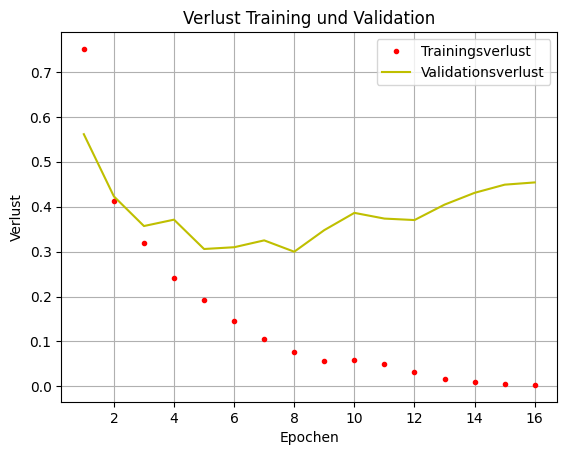

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r.', label='Trainingsverlust')
plt.plot(epochs, val_loss, 'y', label='Validationsverlust')
plt.title('Verlust Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Verlust')
plt.grid()
plt.legend()
plt.savefig('./Metriken/Verlust_1DCNN.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Ausgabe der Genauigkeit für Training und Validierung
***

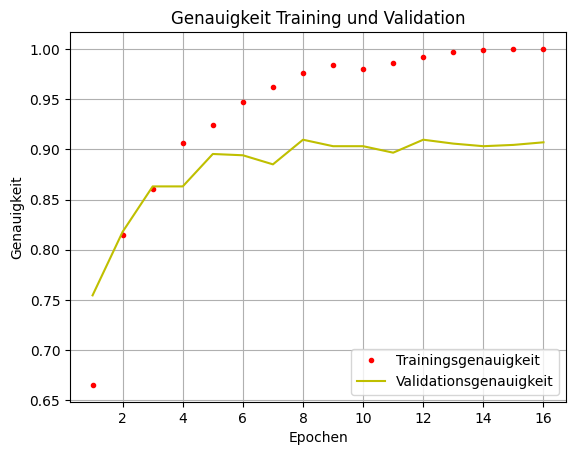

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, acc, 'r.', label='Trainingsgenauigkeit')
plt.plot(epochs, val_acc, 'y', label='Validationsgenauigkeit')
plt.title('Genauigkeit Training und Validation')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.grid()
plt.legend()
plt.savefig('./Metriken/Genauigkeit_1DCNN.png', dpi=300, bbox_inches='tight')
plt.show()

#### ▶️ Modell auf Validierungsdaten anwenden und evaluieren
***

In [12]:
score = model.evaluate(X_val, y_val, verbose=0)
print("Validierungsverlust :", score[0])
print("Validierungsgenauigkeit :", score[1])

Validierungsverlust : 0.45400363206863403
Validierungsgenauigkeit : 0.9069767594337463


### ▶️ Metriken zur Beurteilung der Modellqualität 
***

25/25 [==============================] - 0s 2ms/step


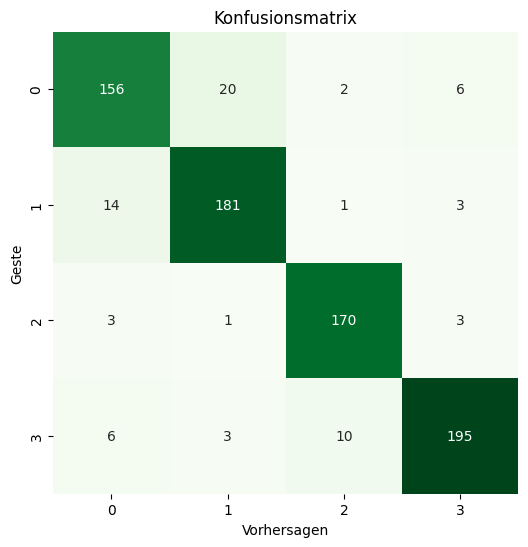

              precision    recall  f1-score   support

           0       0.87      0.85      0.86       184
           1       0.88      0.91      0.90       199
           2       0.93      0.96      0.94       177
           3       0.94      0.91      0.93       214

    accuracy                           0.91       774
   macro avg       0.91      0.91      0.91       774
weighted avg       0.91      0.91      0.91       774



In [13]:
y_test_arg=np.argmax(y_val,axis=1)
y_val = np.argmax(model.predict(X_val),axis=1)
 
cm = confusion_matrix(y_test_arg, y_val)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Greens', cbar=False)
plt.xlabel("Vorhersagen")
plt.ylabel("Geste")
plt.title("Konfusionsmatrix")
plt.show()

print(classification_report(y_test_arg, y_val))